In [1]:
import torch, numpy as np
import gymnasium as gym

In [2]:
env = gym.make('CartPole-v1')

In [3]:
action_number = env.action_space.n

In [4]:
state_size = env.observation_space.shape[0]

In [5]:
gamma = 0.99
lr = 5e-5
hid_layer1 = 64
hid_layer2 = 128
batch_size = 32
q_target_update_frequency = 1000

epsiolon_start = 1.0
epsilon_end = 0.02
epsilon_decay = 10000

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
Q = torch.nn.Sequential(
    torch.nn.Linear(state_size, hid_layer1),
    torch.nn.ReLU(),
    torch.nn.Linear(hid_layer1, hid_layer2),
    torch.nn.ReLU(),
    torch.nn.Linear(hid_layer2, action_number)
).to(device)

Q_target = torch.nn.Sequential(
    torch.nn.Linear(state_size, hid_layer1),
    torch.nn.ReLU(),
    torch.nn.Linear(hid_layer1, hid_layer2),
    torch.nn.ReLU(),
    torch.nn.Linear(hid_layer2, action_number)
).to(device)

In [8]:
optim = torch.optim.Adam(Q.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=100, verbose=True)

In [519]:

# class ReplayBuffer:
#     def __init__(self, capacity, min_replay_size):
#         self.capacity = capacity
#         self.min_replay_size = min_replay_size
#         self.buffer = [None for i in range(capacity)]
#         self.position = 0

#     def push(self, state, action, reward, next_state, done):
#         self.buffer[self.position] = (state, action, reward, next_state, done)
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size):
#         # filter out the None
#         return random.sample([i for i in self.buffer if i is not None], batch_size)

#     def __len__(self):
#         return len(self.buffer)
    
#     def is_ready(self):
#         return len([i for i in self.buffer if i is not None]) >= self.min_replay_size
        

In [9]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity, min_replay_size):
        self.capacity = capacity
        self.min_replay_size = min_replay_size
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)
    
    def is_ready(self):
        return len(self.buffer) >= self.min_replay_size

In [10]:
replay_buffer = ReplayBuffer(50000, 1000)

In [11]:
def step(state, randomness):
    risk = random.random() <= randomness

    q = Q(torch.tensor(state, dtype=torch.float).to(device)).to(device)

    action = random.choice([possible for possible in range(action_number)]) if risk \
        else torch.argmax(q).item()

    new_state, r, done, _, _ = env.step(action)

    replay_buffer.push(state, action, r, new_state, done)

    if not replay_buffer.is_ready():
        return done, None

    batch = replay_buffer.sample(batch_size)

    states = torch.tensor([i[0] for i in batch], dtype=torch.float).to(device)
    actions = torch.tensor([i[1] for i in batch], dtype=torch.long).to(device)
    rewards = torch.tensor([i[2] for i in batch], dtype=torch.float).to(device)
    new_states = torch.tensor([i[3] for i in batch], dtype=torch.float).to(device)
    dones = torch.tensor([i[4] for i in batch], dtype=torch.int).to(device)

    q = Q(states).to(device)
    q_target = Q_target(new_states).to(device)

    y = rewards + (1 - dones)*(gamma*torch.max(q_target, dim=1, keepdim=True)[0])

    q_actions = torch.gather(input=q, dim=1, index=actions.unsqueeze(-1))

    loss = torch.nn.functional.smooth_l1_loss(q_actions, y)

    optim.zero_grad()
    loss.backward()
    optim.step()
    # scheduler.step(loss)

    return done, loss.item()  

In [12]:
def init_population():
    state = env.reset()[0]
    while not replay_buffer.is_ready():
        done, _ = step(state, 1.0)
        if done:
            state = env.reset()[0]

In [13]:
def run_episode(curr_steps):
    episode_steps = 0
    episode_avg_loss = 0

    state = env.reset()[0]

    done = False

    while not done:
        step_randomness = np.interp(curr_steps + episode_steps, [0, epsilon_decay], [epsiolon_start, epsilon_end])
        done, loss = step(state, step_randomness)
        episode_steps += 1

        if (curr_steps + episode_steps) % q_target_update_frequency == 0:
            Q_target.load_state_dict(Q.state_dict())

    episode_avg_loss = (episode_avg_loss * episode_steps + loss) / (episode_steps + 1)

    return episode_steps, episode_avg_loss

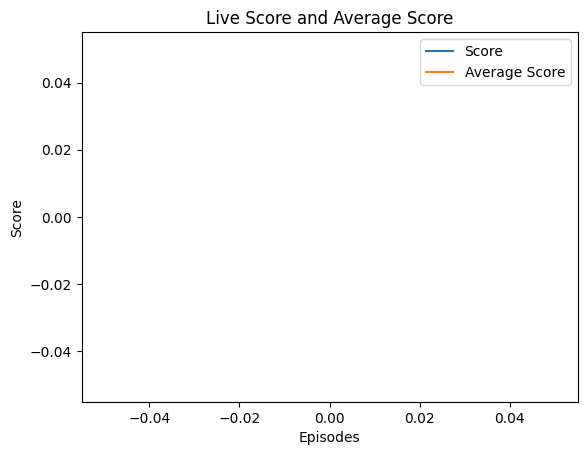

C:\Users\nkvch\AppData\Local\Temp\ipykernel_15680\3932050584.py:31: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.smooth_l1_loss(q_actions, y)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
Saved model.


In [17]:
torch.autograd.set_detect_anomaly(False)

steps = 0
episodes = 0
avg_score = 0

# run the agent, and save the model on process exit
try:
    init_population()
    while True:
        episode_steps, episode_avg_loss = run_episode(steps)

        steps += episode_steps
        episodes += 1
        avg_score = (avg_score * episodes + episode_steps) / (episodes + 1)

        print(f'Episode: {episodes:04d}. Loss: {episode_avg_loss:.5f}. Score: {episode_steps:03d}. Average score: {avg_score:.2f}.')

except KeyboardInterrupt:
    pass
finally:
    torch.save(Q.state_dict(), 'cartpole.dqn.pth')
    print('Saved model.')